In [1]:
## Este es para validar o identificar un usuario previamente ya registrado
import cv2
from matplotlib import pyplot as plt
from numpy import expand_dims
from keras.models import load_model
from sklearn import svm
from sklearn import datasets
from joblib import dump, load
from sklearn.preprocessing import Normalizer
#from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
def tomarfoto():
    print('Presiona la tecla g para capturar la foto')
    print('Presiona la tecla q para salir')
    cap = cv2.VideoCapture(0)
    fotouser =[]
    while True:
        ret,frame = cap.read()
        if not ret:
            print('Fallo en lectura de la camara')
            break
        key = cv2.waitKey(1)
        if key == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break
        cv2.imshow('Camera', frame)
        if key == ord('g'):
            fotouser = frame     #Guarda la foto
            print('foto capturada exitosamente')
    return fotouser    # La funcion retorna la foto

In [3]:
def Getear(fotouser):
    earClassif = cv2.CascadeClassifier('cascade.xml')
    gray = cv2.cvtColor(fotouser, cv2.COLOR_BGR2GRAY)
    fotouser = cv2.cvtColor(fotouser, cv2.COLOR_BGR2RGB)
    ear = earClassif.detectMultiScale(gray, scaleFactor=1.07, minNeighbors=15)
    for (x,y,w,h) in ear:
        out = fotouser[y-5:y+h+10,x-10:x+w+10]
    plt.subplot(1,2,1)
    plt.imshow(fotouser)
    plt.subplot(1,2,2)
    plt.imshow(out)
    plt.show()
    return out

In [4]:
def getembebeding(ear_pixels):   #retorna el embebeding de la oreja
    required_size = (160,160)
    ear = cv2.resize(ear_pixels, required_size)
    model = load_model('facenet_keras.h5')
    ear = ear.astype('float32')
    # standardize pixel values across channels (global)  #esto es requisito para el modelo Facenet
    mean, std = ear.mean(), ear.std()
    ear = (ear - mean) / std
    # transform ear into one sample
    samples = expand_dims(ear, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [5]:
def uservalidation(user, model, encoder):
    foto = tomarfoto()
    ear = Getear(foto)
    print('¿Continuar? Si : y | No : n')
    conti = input()
    if conti == 'y':
        embeding = getembebeding(ear)      ### Obtiene caracteristicas de la oreja
    
        embeding = expand_dims(embeding, axis=0)
        in_encoder = Normalizer(norm='l2')
        embeding = in_encoder.transform(embeding)   # Normaliza el vector de caracteristicas
    
        yhat_class = model.predict(embeding)         # Ingresa en el SVM, obtiene la clase, es decir, el usuario predicho
        yhat_prob = model.predict_proba(embeding)    # Obtiene la probabilidad de la clase
        class_index = yhat_class[0]                  # Obtiene la clase o nombre de usuario predicho
        class_probability = yhat_prob[0,class_index] * 100    # Calcula la probabilidad
        predict_names = encoder.inverse_transform(yhat_class)
        print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
        print('Expected: %s' % user)

In [6]:
print('ingrese nombre de usuario : ')
user = input()
model = load('Models/Bigmodel.joblib')
out_encoder = load('Models/BigOut_encoder.joblib')

ingrese nombre de usuario : 
Fernando


Presiona la tecla g para capturar la foto
Presiona la tecla q para salir
foto capturada exitosamente


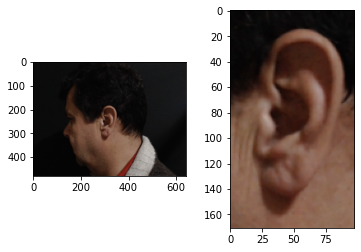

¿Continuar? Si : y | No : n
y


C:\Users\JOSE\anaconda3\envs\biometrics\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Predicted: Fernando (23.480)
Expected: Fernando


In [7]:
uservalidation(user, model, out_encoder)